# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=True, enhanced=True)


Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 4/4 [00:16<00:00,  4.13s/it]


# Methods

In [5]:
def count_wrong_timestamps(dataframe: pd.DataFrame):
    datetime_columns = [
        "time_call_received", "time_call_answered", "time_ambulance_notified",
        "time_dispatch", "time_arrival_scene", "time_departure_scene",
        "time_arrival_hospital", "time_available"
    ]

    # Count violations for each pair of datetime columns
    for i in range(len(datetime_columns) - 1):
        first_col = datetime_columns[i]
        second_col = datetime_columns[i + 1]
        
        # Count where the first date is after the second date
        count = dataframe[dataframe[first_col] > dataframe[second_col]].shape[0]
        print(f"{first_col} to {second_col}: {count}")


In [6]:
def find_first_problematic_row(dataframe: pd.DataFrame):
    # Convert columns to datetime if they're not already
    dataframe['time_call_received'] = pd.to_datetime(dataframe['time_call_received'])
    dataframe['time_call_answered'] = pd.to_datetime(dataframe['time_call_answered'])

    # Find the first row where time_call_received is after time_call_answered
    problematic_rows = dataframe[dataframe['time_call_received'] > dataframe['time_call_answered']]
    if not problematic_rows.empty:
        first_problematic_index = problematic_rows.index[0]
        print(f"First problematic row index: {first_problematic_index}")
        return first_problematic_index
    else:
        print("No problematic rows found.")
        return None


In [7]:
def outlier_plotting(
    dataframe: pd.DataFrame,
    column_start: str,
    column_end: str,
    triage_impression: str = None,
    log_scale: bool = False,
    IQR_multiplier: float = 1.5,
    z_score_threshold: float = 3,
    bounds_to_use: str = "z"
):
    plotter.plot_time_difference_distribution(
        dataframe,
        column_start,
        column_end,
        triage_impression,
        log_scale
    )

    before_size = dataframe.shape[0]

    dataframe = data_preprocessor._drop_outside_bounds(
        dataframe,
        column_start,
        column_end,
        triage_impression,
        z_score_threshold,
        IQR_multiplier,
        bounds_to_use,
        verbose=True
    )

    plotter.plot_time_difference_distribution(
        dataframe,
        column_start,
        column_end,
        triage_impression,
        log_scale
    )

    print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


# Main

In [8]:
count_wrong_timestamps(data_loader.processed_incidents_df)


time_call_received to time_call_answered: 69721
time_call_answered to time_ambulance_notified: 7688
time_ambulance_notified to time_dispatch: 13
time_dispatch to time_arrival_scene: 34
time_arrival_scene to time_departure_scene: 2
time_departure_scene to time_arrival_hospital: 2
time_arrival_hospital to time_available: 34


In [9]:
dataframe = data_preprocessor._remove_duplicates(data_loader.processed_incidents_df)
dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)
dataframe = data_preprocessor._remove_other_resource_types(dataframe)
dataframe = data_preprocessor._count_resources_sent(dataframe)
dataframe = data_preprocessor._remove_extra_resources(dataframe)

dataframe = dataframe.sort_values(by="time_call_received")


In [10]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_answered: 29433
time_call_answered to time_ambulance_notified: 2496
time_ambulance_notified to time_dispatch: 5
time_dispatch to time_arrival_scene: 17
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 6


In [11]:
dataframe["triage_impression_during_call"].value_counts()


triage_impression_during_call
H     145959
A     137909
V1     41852
V2     32787
V         14
Name: count, dtype: int64

In [12]:
dataframe = data_preprocessor._remove_other_triage_impressions(dataframe)


In [13]:
print(dataframe["triage_impression_during_call"].value_counts())

dataframe.info()


triage_impression_during_call
H     145959
A     137909
V1     41852
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 325726 entries, 147884 to 728620
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  325720 non-null  object        
 1   resource_id                    325726 non-null  object        
 2   resource_type                  325726 non-null  object        
 3   resources_sent                 325726 non-null  int64         
 4   time_call_received             325726 non-null  datetime64[ns]
 5   time_call_answered             325726 non-null  datetime64[ns]
 6   time_ambulance_notified        325616 non-null  datetime64[ns]
 7   time_dispatch                  322812 non-null  datetime64[ns]
 8   time_arrival_scene             301055 non-null  datetime64[ns]
 9   time_departure_scene           255399 non

In [14]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_answered: 2372
time_call_answered to time_ambulance_notified: 2483
time_ambulance_notified to time_dispatch: 4
time_dispatch to time_arrival_scene: 14
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 4


In [15]:
dataframe = data_preprocessor._remove_wrong_timestamps(dataframe)


In [16]:
dataframe["triage_impression_during_call"].value_counts()


triage_impression_during_call
H     145320
A     136151
V1     41744
Name: count, dtype: int64

In [17]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_answered: 2372
time_call_answered to time_ambulance_notified: 0
time_ambulance_notified to time_dispatch: 0
time_dispatch to time_arrival_scene: 0
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 0


In [18]:
dataframe = data_preprocessor._fix_timestamps(dataframe)


In [19]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_answered: 0
time_call_answered to time_ambulance_notified: 0
time_ambulance_notified to time_dispatch: 0
time_dispatch to time_arrival_scene: 0
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 0


In [20]:
data_loader.execute(clean=False, processed=True, enhanced=False)

dataframe = data_preprocessor._remove_duplicates(data_loader.processed_incidents_df)
dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)
dataframe = data_preprocessor._remove_other_resource_types(dataframe)
dataframe = data_preprocessor._count_resources_sent(dataframe)
dataframe = data_preprocessor._remove_extra_resources(dataframe)
dataframe = data_preprocessor._remove_other_triage_impressions(dataframe)
dataframe = data_preprocessor._remove_wrong_timestamps(dataframe)
dataframe = data_preprocessor._fix_timestamps(dataframe)
dataframe = data_preprocessor._remove_na(dataframe)


Loading dataset: 100%|██████████| 2/2 [00:12<00:00,  6.05s/it]


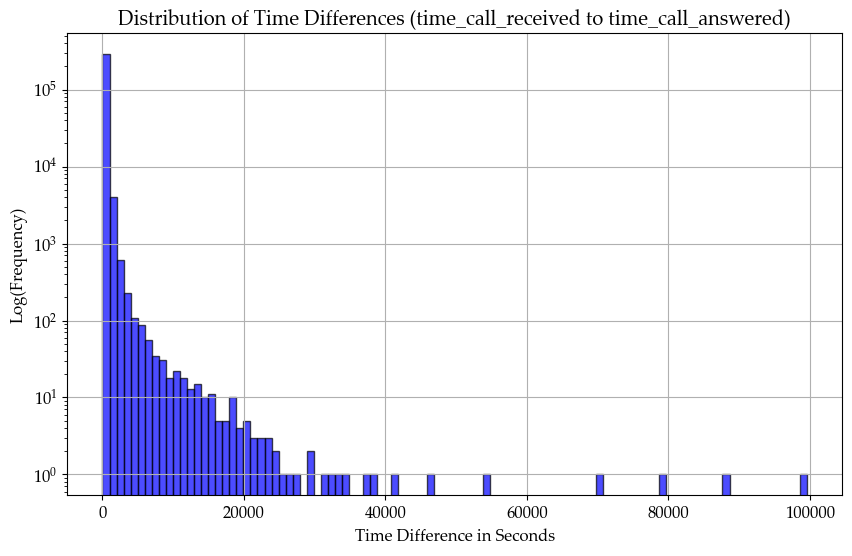

Mean time difference: 183.60562373354622 seconds
Median time difference: 95.0 seconds
Standard deviation of time difference: 602.1695433930106 seconds
Maximum time difference: 99595.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 1174.42 seconds
Suggested IQR lower bound for dropping rows: 7.01 seconds
Suggested Z-Score upper bound for dropping rows: 2330.13 seconds
Suggested Z-Score lower bound for dropping rows: 3.06 seconds


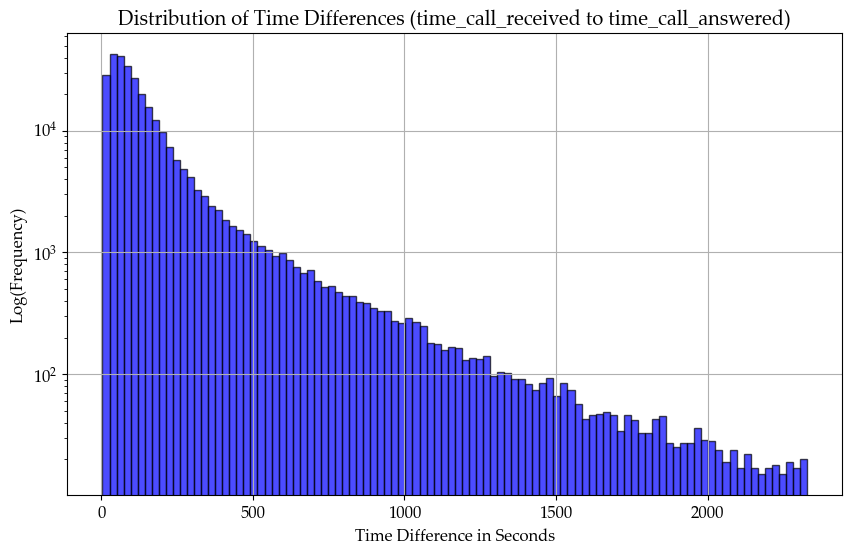

Mean time difference: 163.2000038300614 seconds
Median time difference: 95.0 seconds
Standard deviation of time difference: 217.7846122186522 seconds
Maximum time difference: 2328.0 seconds
Minimum time difference: 4.0 seconds


Dropped 2716 rows


In [21]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_call_received",
    column_end="time_call_answered",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


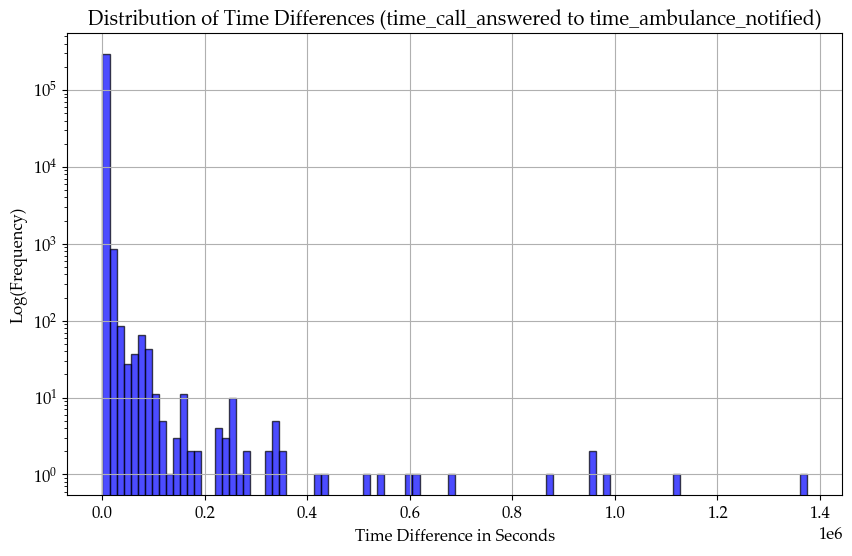

Mean time difference: 741.0357226323531 seconds
Median time difference: 78.0 seconds
Standard deviation of time difference: 6826.296642200894 seconds
Maximum time difference: 1375375.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 10716.52 seconds
Suggested IQR lower bound for dropping rows: -0.12 seconds
Suggested Z-Score upper bound for dropping rows: 19708.82 seconds
Suggested Z-Score lower bound for dropping rows: -0.36 seconds


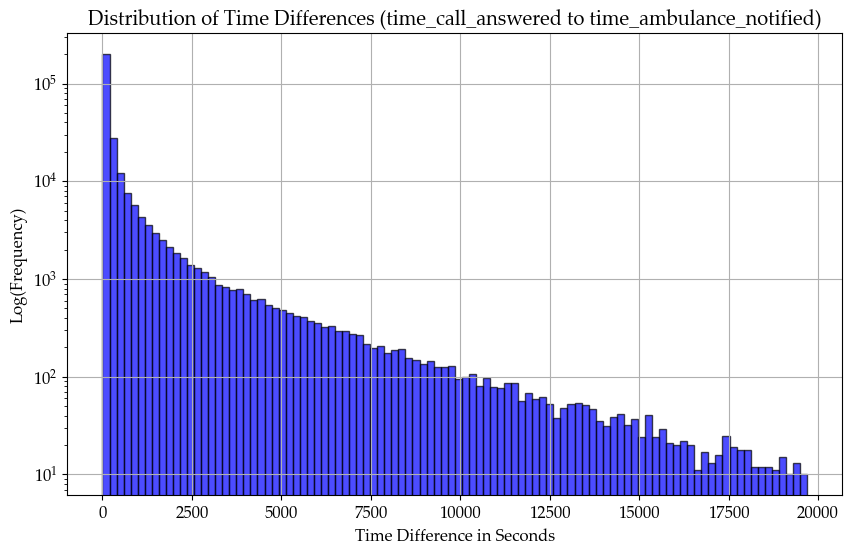

Mean time difference: 595.2041967384718 seconds
Median time difference: 77.0 seconds
Standard deviation of time difference: 1617.0846413698378 seconds
Maximum time difference: 19688.0 seconds
Minimum time difference: 0.0 seconds


Dropped 548 rows


In [22]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_call_answered",
    column_end="time_ambulance_notified",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


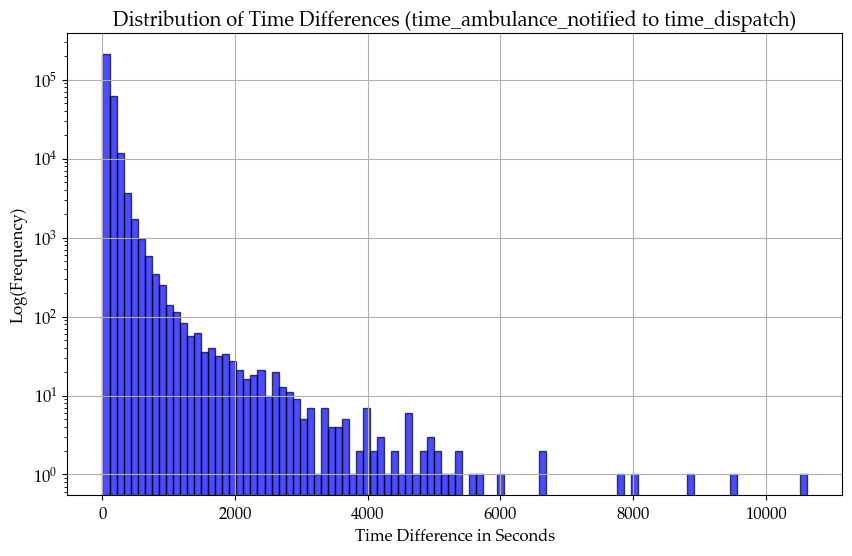

Mean time difference: 88.44578367083213 seconds
Median time difference: 68.0 seconds
Standard deviation of time difference: 144.1809928516526 seconds
Maximum time difference: 10626.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 3971.43 seconds
Suggested IQR lower bound for dropping rows: -0.68 seconds
Suggested Z-Score upper bound for dropping rows: 2726.77 seconds
Suggested Z-Score lower bound for dropping rows: -0.34 seconds


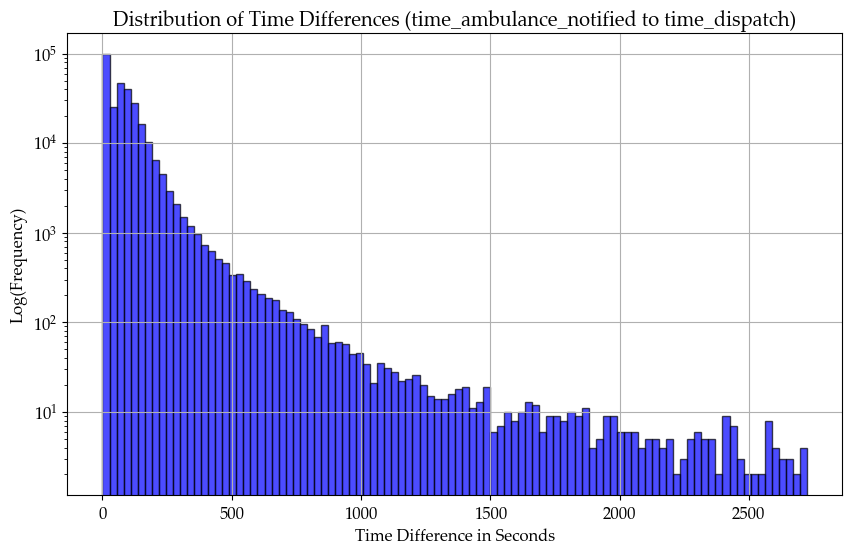

Mean time difference: 87.00873281371946 seconds
Median time difference: 68.0 seconds
Standard deviation of time difference: 120.08727409262372 seconds
Maximum time difference: 2725.0 seconds
Minimum time difference: 0.0 seconds


Dropped 107 rows


In [23]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_ambulance_notified",
    column_end="time_dispatch",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


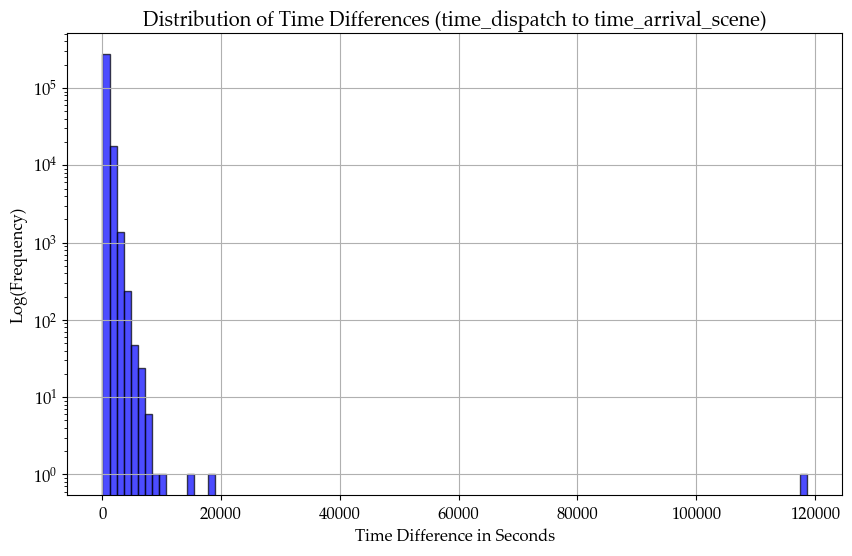

Mean time difference: 549.9985702698616 seconds
Median time difference: 459.0 seconds
Standard deviation of time difference: 478.4923764908389 seconds
Maximum time difference: 118709.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 2850.59 seconds
Suggested IQR lower bound for dropping rows: 68.96 seconds
Suggested Z-Score upper bound for dropping rows: 8456.31 seconds
Suggested Z-Score lower bound for dropping rows: 17.44 seconds


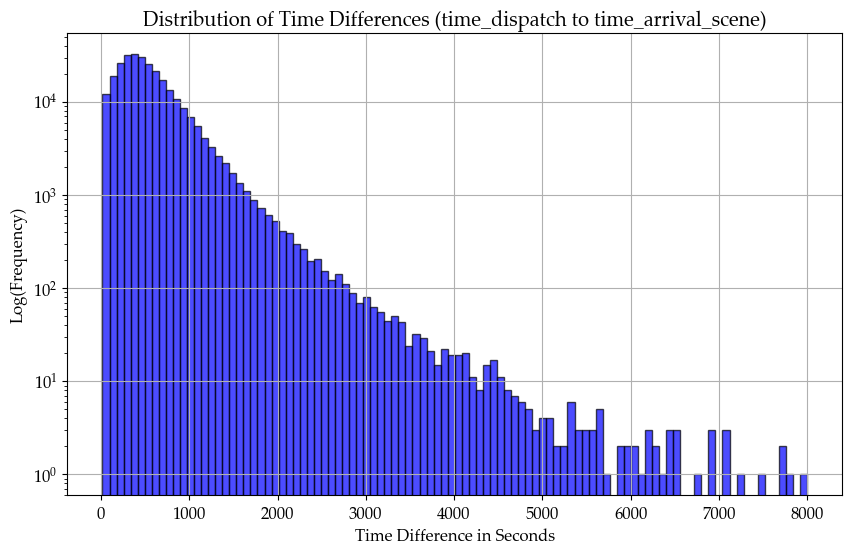

Mean time difference: 561.7578526716833 seconds
Median time difference: 468.0 seconds
Standard deviation of time difference: 419.4339224975611 seconds
Maximum time difference: 7996.0 seconds
Minimum time difference: 18.0 seconds


Dropped 6443 rows


In [24]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_dispatch",
    column_end="time_arrival_scene",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


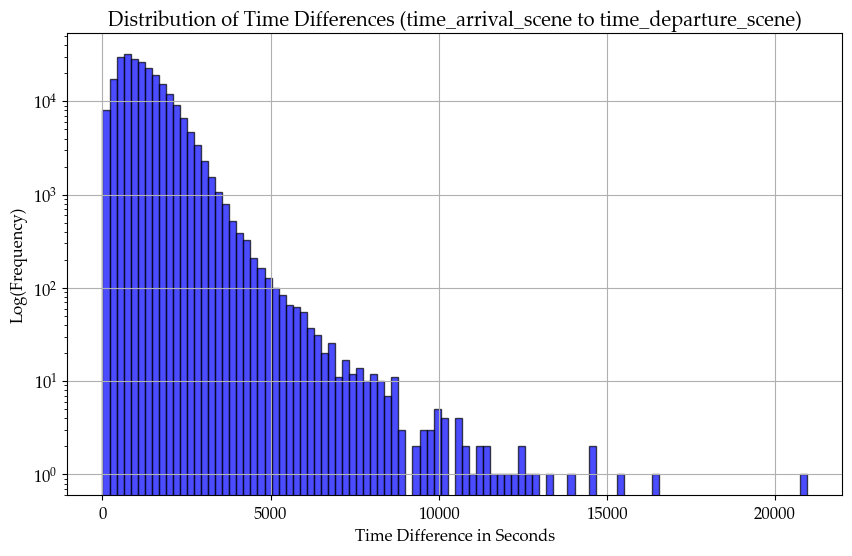

Mean time difference: 1242.4266829042272 seconds
Median time difference: 1091.0 seconds
Standard deviation of time difference: 807.4277453884094 seconds
Maximum time difference: 20957.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 6536.08 seconds
Suggested IQR lower bound for dropping rows: 167.77 seconds
Suggested Z-Score upper bound for dropping rows: 18852.17 seconds
Suggested Z-Score lower bound for dropping rows: 45.88 seconds


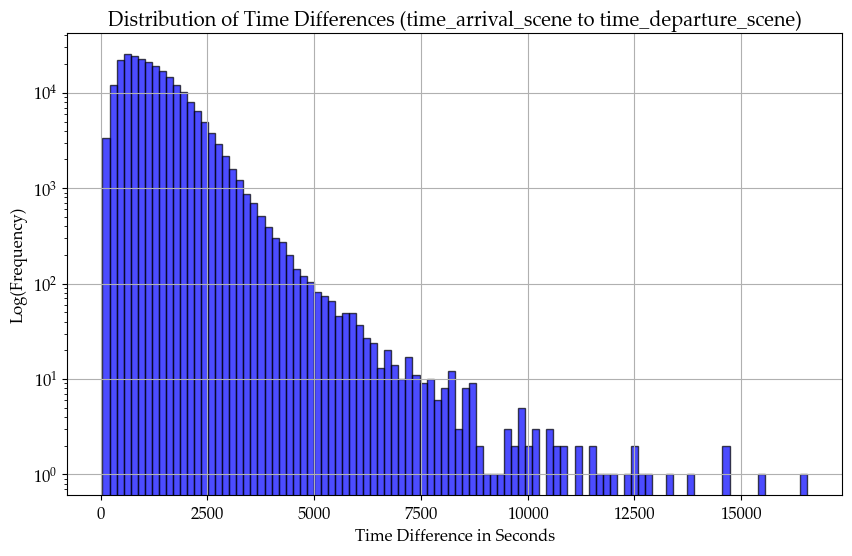

Mean time difference: 1266.9933713071698 seconds
Median time difference: 1109.0 seconds
Standard deviation of time difference: 795.1249975387901 seconds
Maximum time difference: 16546.0 seconds
Minimum time difference: 46.0 seconds


Dropped 4767 rows


In [25]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_arrival_scene",
    column_end="time_departure_scene",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


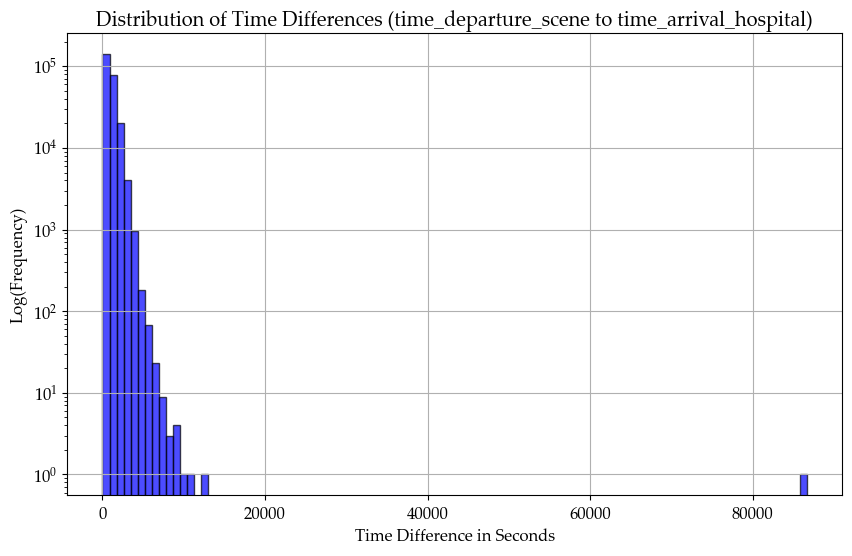

Mean time difference: 920.4642425137056 seconds
Median time difference: 768.0 seconds
Standard deviation of time difference: 652.364471802832 seconds
Maximum time difference: 86696.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 4249.17 seconds
Suggested IQR lower bound for dropping rows: 134.37 seconds
Suggested Z-Score upper bound for dropping rows: 8281.54 seconds
Suggested Z-Score lower bound for dropping rows: 62.09 seconds


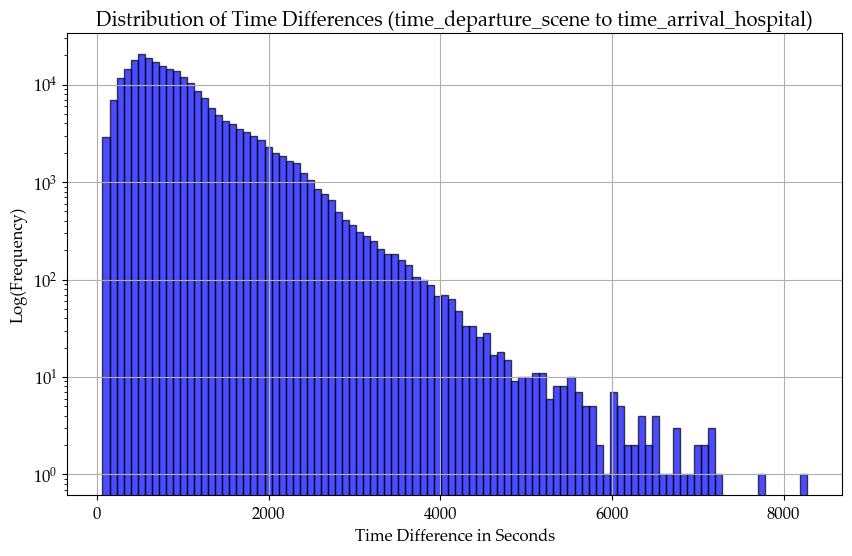

Mean time difference: 929.0312954363756 seconds
Median time difference: 774.0 seconds
Standard deviation of time difference: 622.9936028346237 seconds
Maximum time difference: 8273.0 seconds
Minimum time difference: 63.0 seconds


Dropped 2470 rows


In [26]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_departure_scene",
    column_end="time_arrival_hospital",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


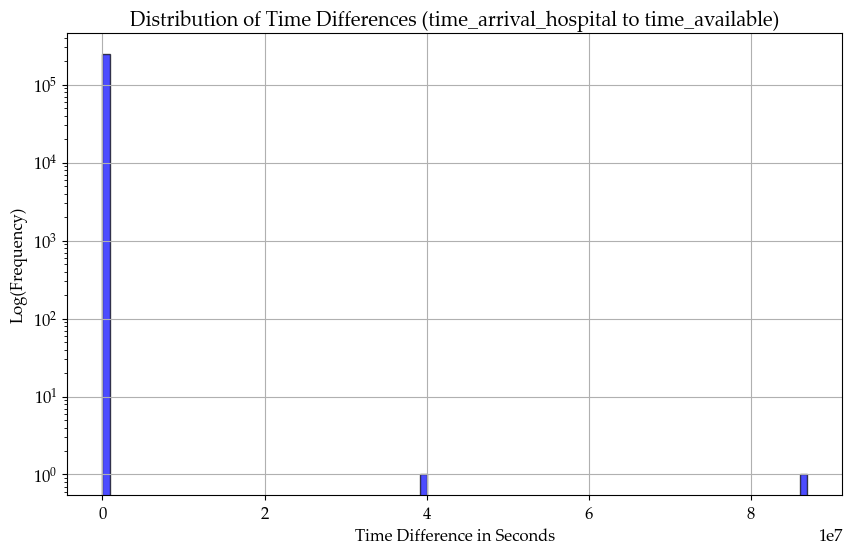

Mean time difference: 1586.5729070563682 seconds
Median time difference: 873.0 seconds
Standard deviation of time difference: 193178.32235546916 seconds
Maximum time difference: 86919844.0 seconds
Minimum time difference: 0.0 seconds
Suggested IQR upper bound for dropping rows: 3706.44 seconds
Suggested IQR lower bound for dropping rows: 206.66 seconds
Suggested Z-Score upper bound for dropping rows: 7984.52 seconds
Suggested Z-Score lower bound for dropping rows: 88.85 seconds


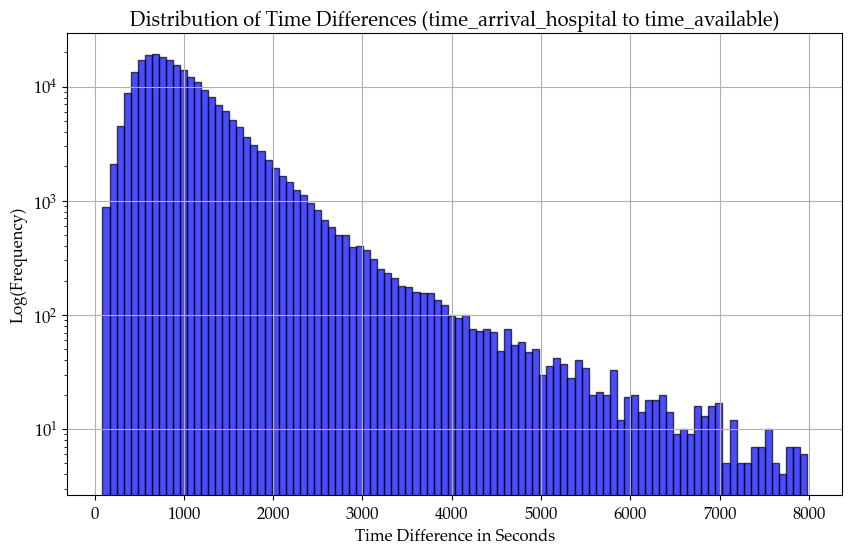

Mean time difference: 1032.0085101611076 seconds
Median time difference: 879.0 seconds
Standard deviation of time difference: 650.0880919841786 seconds
Maximum time difference: 7977.0 seconds
Minimum time difference: 89.0 seconds


Dropped 3108 rows


In [27]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_arrival_hospital",
    column_end="time_available",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


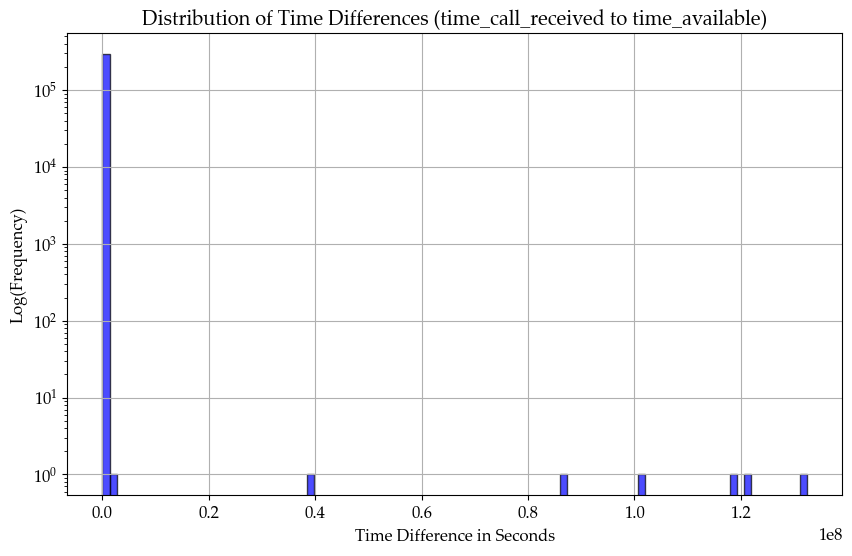

Mean time difference: 6663.241145653784 seconds
Median time difference: 4013.0 seconds
Standard deviation of time difference: 474621.81503358815 seconds
Maximum time difference: 132452289.0 seconds
Minimum time difference: 18.0 seconds
Suggested IQR upper bound for dropping rows: 11868.89 seconds
Suggested IQR lower bound for dropping rows: 1340.13 seconds
Suggested Z-Score upper bound for dropping rows: 18053.25 seconds
Suggested Z-Score lower bound for dropping rows: 871.48 seconds


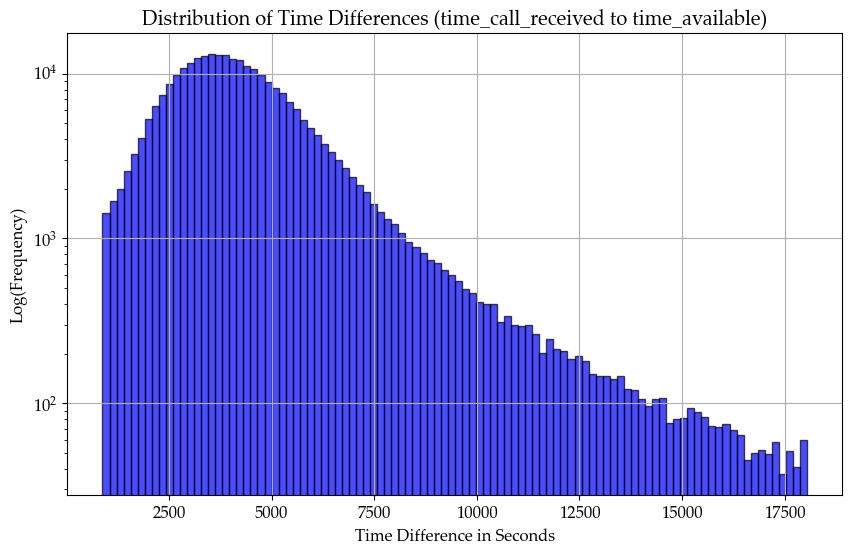

Mean time difference: 4399.534080361497 seconds
Median time difference: 4018.0 seconds
Standard deviation of time difference: 2110.784635468893 seconds
Maximum time difference: 18048.0 seconds
Minimum time difference: 872.0 seconds


Dropped 4027 rows


In [28]:
outlier_plotting(
    dataframe,
    triage_impression=None,
    column_start="time_call_received",
    column_end="time_available",
    log_scale=True,
    IQR_multiplier=1.5,
    z_score_threshold=3,
    bounds_to_use="z"
)


In [29]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 290964 entries, 147884 to 728620
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  290964 non-null  object        
 1   resource_id                    290964 non-null  object        
 2   resource_type                  290964 non-null  object        
 3   resources_sent                 290964 non-null  int64         
 4   time_call_received             290964 non-null  datetime64[ns]
 5   time_call_answered             290964 non-null  datetime64[ns]
 6   time_ambulance_notified        290964 non-null  datetime64[ns]
 7   time_dispatch                  290964 non-null  datetime64[ns]
 8   time_arrival_scene             290964 non-null  datetime64[ns]
 9   time_departure_scene           243879 non-null  datetime64[ns]
 10  time_arrival_hospital          243879 non-null  datetime64[ns]
 11  